In [ ]:
## organizing the files

import os

MIMIC_PATH = '/Users/azmannads/Downloads/Dr. Zhang/mimic-iv-2.2/'

files_to_check = [
    'hosp/patients.csv.gz',
    'hosp/admissions.csv.gz',
    'hosp/diagnoses_icd.csv.gz',
    'hosp/labevents.csv.gz',
    'icu/icustays.csv.gz',
    'icu/chartevents.csv.gz'
]

print("Checking files...")
for file in files_to_check:
    full_path = os.path.join(MIMIC_PATH, file)
    if os.path.exists(full_path):
        size = os.path.getsize(full_path) / (1024**3)
        print(f"✓ {file} ({size:.2f} GB)")
    else:
        print(f"✗ {file} - NOT FOUND")

Checking files...
✓ hosp/patients.csv.gz (0.00 GB)
✓ hosp/admissions.csv.gz (0.02 GB)
✓ hosp/diagnoses_icd.csv.gz (0.03 GB)
✓ hosp/labevents.csv.gz (2.41 GB)
✓ icu/icustays.csv.gz (0.00 GB)
✓ icu/chartevents.csv.gz (3.26 GB)


In [2]:
## Run the extraction

### Configuration

# ============================================================================
# MIMIC-IV SEPSIS COHORT EXTRACTION - COMPLETE SETUP
# Author: Azman Nads
# ============================================================================

import pandas as pd
import numpy as np
import os
from pathlib import Path
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

MIMIC_PATH = '/Users/azmannads/Downloads/Dr. Zhang/mimic-iv-2.2/'
OUTPUT_PATH = '/Users/azmannads/Downloads/Dr. Zhang'
INTERMEDIATE_PATH = os.path.join(OUTPUT_PATH, 'intermediate')
FINAL_PATH = os.path.join(OUTPUT_PATH, 'final')
LOG_PATH = os.path.join(OUTPUT_PATH, 'logs')

# Create directories
Path(INTERMEDIATE_PATH).mkdir(parents=True, exist_ok=True)
Path(FINAL_PATH).mkdir(parents=True, exist_ok=True)
Path(LOG_PATH).mkdir(parents=True, exist_ok=True)

# Parameters
MIN_AGE = 18
MISSING_THRESHOLD = 0.3
RANDOM_SEED = 42

# Item IDs
LAB_ITEMS = {
    'ALT': [50861],
    'AST': [50878],
    'Lactate': [50813],
    'Sodium': [50983, 50824],
    'Chloride': [50902, 50806],
    'Platelets': [51265]
}

VITAL_ITEMS = {
    'HR': [220045],
    'RR': [220210, 224690],
}

GCS_ITEMS = [220739, 223901, 223900, 198]

SEPSIS_ICD10 = ['A40', 'A41', 'R65']
SEPSIS_ICD9 = ['995', '785']

print("Configuration loaded successfully!")
print(f"   MIMIC Path: {MIMIC_PATH}")
print(f"   Output Path: {OUTPUT_PATH}")

Configuration loaded successfully!
   MIMIC Path: /Users/azmannads/Downloads/Dr. Zhang/mimic-iv-2.2/
   Output Path: /Users/azmannads/Downloads/Dr. Zhang


In [ ]:
## Extract base cohort

# ============================================================================
# STEP 1: EXTRACT BASE COHORT
# ============================================================================

print("="*70)
print("STEP 1: EXTRACTING BASE COHORT".center(70))
print("="*70)

# Load core tables
print("\n1. Loading MIMIC-IV tables...")
patients = pd.read_csv(f'{MIMIC_PATH}hosp/patients.csv.gz', compression='gzip')
print(f"  Patients: {len(patients):,}")

admissions = pd.read_csv(f'{MIMIC_PATH}hosp/admissions.csv.gz', compression='gzip')
print(f"  Admissions: {len(admissions):,}")

diagnoses = pd.read_csv(f'{MIMIC_PATH}hosp/diagnoses_icd.csv.gz', compression='gzip')
print(f"  Diagnoses: {len(diagnoses):,}")

# Identify sepsis
print("\n2. Identifying sepsis patients...")
all_sepsis_codes = SEPSIS_ICD10 + SEPSIS_ICD9
sepsis_diagnoses = diagnoses[
    diagnoses['icd_code'].str.startswith(tuple(all_sepsis_codes), na=False)
]
sepsis_hadm_ids = sepsis_diagnoses['hadm_id'].unique()
print(f"  Sepsis admissions: {len(sepsis_hadm_ids):,}")

# Filter surgical
print("\n3. Filtering for surgical admissions...")
surgical_sepsis = admissions[
    (admissions['hadm_id'].isin(sepsis_hadm_ids)) &
    (
        (admissions['admission_type'].str.contains('SURGICAL', case=False, na=False)) |
        (admissions['admission_location'].str.contains('SURGERY', case=False, na=False))
    )
]
print(f"  Surgical sepsis: {len(surgical_sepsis):,}")

# Add demographics
print("\n4. Adding demographics...")
cohort = surgical_sepsis.merge(patients, on='subject_id', how='left')

# Calculate age
cohort['admittime'] = pd.to_datetime(cohort['admittime'])
cohort['age'] = cohort['admittime'].dt.year - cohort['anchor_year'] + cohort['anchor_age']
cohort = cohort[cohort['age'] >= MIN_AGE]
print(f"  Adults (≥{MIN_AGE}): {len(cohort):,}")

# Survival variables
cohort['dischtime'] = pd.to_datetime(cohort['dischtime'])
cohort['los_days'] = (cohort['dischtime'] - cohort['admittime']).dt.total_seconds() / (24 * 3600)
cohort['Time'] = cohort['los_days']
cohort['Event'] = cohort['hospital_expire_flag']

print(f"  Deaths: {cohort['Event'].sum():,} ({cohort['Event'].mean()*100:.1f}%)")

# Select columns
cohort_base = cohort[[
    'subject_id', 'hadm_id', 'age', 'gender', 
    'admittime', 'dischtime', 'Time', 'Event'
]].copy()

cohort_base = cohort_base.rename(columns={'age': 'Age', 'gender': 'Sex'})

# Save
cohort_file = os.path.join(INTERMEDIATE_PATH, 'cohort_base.csv')
cohort_base.to_csv(cohort_file, index=False)
print(f"\nSaved: {cohort_file}")
print(f"   Cohort: {len(cohort_base):,} patients")

                    STEP 1: EXTRACTING BASE COHORT                    

1. Loading MIMIC-IV tables...
  ✓ Patients: 364,627
  ✓ Admissions: 546,028
  ✓ Diagnoses: 6,364,488

2. Identifying sepsis patients...
  ✓ Sepsis admissions: 32,065

3. Filtering for surgical admissions...
  ✓ Surgical sepsis: 852

4. Adding demographics...
  ✓ Adults (≥18): 852
  ✓ Deaths: 59 (6.9%)

✅ Saved: /Users/azmannads/Downloads/Dr. Zhang/intermediate/cohort_base.csv
   Cohort: 852 patients


In [ ]:
##Extract labs

# ============================================================================
# STEP 2: EXTRACT LABS
# ============================================================================

print("\n" + "="*70)
print("STEP 2: EXTRACTING LABORATORY VALUES".center(70))
print("="*70)

# Load cohort
cohort = pd.read_csv(os.path.join(INTERMEDIATE_PATH, 'cohort_base.csv'))
hadm_ids = cohort['hadm_id'].values

# Get all lab item IDs
all_lab_ids = [item for items in LAB_ITEMS.values() for item in items]
item_to_name = {}
for name, ids in LAB_ITEMS.items():
    for item_id in ids:
        item_to_name[item_id] = name

print("\n1. Extracting lab values (this may take 5-10 minutes)...")
labs_list = []
chunk_count = 0

for chunk in pd.read_csv(
    f'{MIMIC_PATH}hosp/labevents.csv.gz',
    compression='gzip',
    chunksize=1000000,
    usecols=['hadm_id', 'itemid', 'valuenum']
):
    chunk_count += 1
    if chunk_count % 5 == 0:
        print(f"  Processing chunk {chunk_count}...", end='\r')
    
    chunk_filtered = chunk[
        (chunk['hadm_id'].isin(hadm_ids)) &
        (chunk['itemid'].isin(all_lab_ids)) &
        (chunk['valuenum'].notna())
    ]
    
    if len(chunk_filtered) > 0:
        labs_list.append(chunk_filtered)

print()

if labs_list:
    labs = pd.concat(labs_list, ignore_index=True)
    print(f"  Extracted {len(labs):,} lab measurements")
    
    # Pivot
    labs['lab_name'] = labs['itemid'].map(item_to_name)
    labs_first = labs.groupby(['hadm_id', 'lab_name'])['valuenum'].first().reset_index()
    labs_wide = labs_first.pivot(
        index='hadm_id',
        columns='lab_name',
        values='valuenum'
    ).reset_index()
    
    # Merge
    cohort = cohort.merge(labs_wide, on='hadm_id', how='left')
    
    # Rename
    cohort = cohort.rename(columns={
        'Lactate': 'Lac',
        'Sodium': 'Na',
        'Chloride': 'Cl',
        'Platelets': 'Plt'
    })
    
    # Coverage
    print("\n2. Lab coverage:")
    for lab in ['ALT', 'AST', 'Lac', 'Na', 'Cl', 'Plt']:
        if lab in cohort.columns:
            pct = cohort[lab].notna().sum() / len(cohort) * 100
            print(f"  {lab}: {cohort[lab].notna().sum():,} ({pct:.1f}%)")

# Save
labs_file = os.path.join(INTERMEDIATE_PATH, 'cohort_with_labs.csv')
cohort.to_csv(labs_file, index=False)
print(f"\nSaved: {labs_file}")


                 STEP 2: EXTRACTING LABORATORY VALUES                 

1. Extracting lab values (this may take 5-10 minutes)...
  Processing chunk 155...
  ✓ Extracted 59,253 lab measurements

2. Lab coverage:
  ALT: 366 (43.0%)
  AST: 373 (43.8%)
  Lac: 453 (53.2%)
  Na: 790 (92.7%)
  Cl: 790 (92.7%)
  Plt: 796 (93.4%)

✅ Saved: /Users/azmannads/Downloads/Dr. Zhang/intermediate/cohort_with_labs.csv


In [ ]:
## Extract vitals

# ============================================================================
# STEP 3: EXTRACT VITALS
# ============================================================================

print("\n" + "="*70)
print("STEP 3: EXTRACTING VITAL SIGNS".center(70))
print("="*70)

# Load cohort
cohort = pd.read_csv(os.path.join(INTERMEDIATE_PATH, 'cohort_with_labs.csv'))

# Load ICU stays
print("\n1. Loading ICU stays...")
icustays = pd.read_csv(
    f'{MIMIC_PATH}icu/icustays.csv.gz',
    compression='gzip',
    usecols=['subject_id', 'hadm_id', 'stay_id']
)

cohort_icu = cohort.merge(icustays, on=['subject_id', 'hadm_id'], how='left')
stay_ids = cohort_icu['stay_id'].dropna().unique()
print(f"  ICU stays: {len(stay_ids):,}")

if len(stay_ids) > 0:
    # Get vital item IDs
    all_vital_ids = [item for items in VITAL_ITEMS.values() for item in items]
    item_to_name = {}
    for name, ids in VITAL_ITEMS.items():
        for item_id in ids:
            item_to_name[item_id] = name
    
    print("\n2. Extracting vitals (this may take 10-15 minutes)...")
    vitals_list = []
    chunk_count = 0
    
    for chunk in pd.read_csv(
        f'{MIMIC_PATH}icu/chartevents.csv.gz',
        compression='gzip',
        chunksize=1000000,
        usecols=['stay_id', 'itemid', 'valuenum']
    ):
        chunk_count += 1
        if chunk_count % 10 == 0:
            print(f"  Processing chunk {chunk_count}...", end='\r')
        
        chunk_filtered = chunk[
            (chunk['stay_id'].isin(stay_ids)) &
            (chunk['itemid'].isin(all_vital_ids)) &
            (chunk['valuenum'].notna())
        ]
        
        if len(chunk_filtered) > 0:
            vitals_list.append(chunk_filtered)
    
    print()
    
    if vitals_list:
        vitals = pd.concat(vitals_list, ignore_index=True)
        print(f"  Extracted {len(vitals):,} vital measurements")
        
        # Pivot
        vitals['vital_name'] = vitals['itemid'].map(item_to_name)
        vitals_mean = vitals.groupby(['stay_id', 'vital_name'])['valuenum'].mean().reset_index()
        vitals_wide = vitals_mean.pivot(
            index='stay_id',
            columns='vital_name',
            values='valuenum'
        ).reset_index()
        
        # Merge
        cohort_icu = cohort_icu.merge(vitals_wide, on='stay_id', how='left')
        vital_cols = [c for c in ['HR', 'RR'] if c in cohort_icu.columns]
        
        cohort = cohort.merge(
            cohort_icu[['hadm_id'] + vital_cols].drop_duplicates('hadm_id'),
            on='hadm_id',
            how='left'
        )
        
        # Coverage
        print("\n3. Vital coverage:")
        for vital in ['HR', 'RR']:
            if vital in cohort.columns:
                pct = cohort[vital].notna().sum() / len(cohort) * 100
                print(f"  {vital}: {cohort[vital].notna().sum():,} ({pct:.1f}%)")

# Save
vitals_file = os.path.join(INTERMEDIATE_PATH, 'cohort_with_vitals.csv')
cohort.to_csv(vitals_file, index=False)
print(f"\nSaved: {vitals_file}")


                    STEP 3: EXTRACTING VITAL SIGNS                    

1. Loading ICU stays...
  ✓ ICU stays: 501

2. Extracting vitals (this may take 10-15 minutes)...
  Processing chunk 430...
  ✓ Extracted 235,798 vital measurements

3. Vital coverage:
  HR: 378 (44.4%)
  RR: 378 (44.4%)

✅ Saved: /Users/azmannads/Downloads/Dr. Zhang/intermediate/cohort_with_vitals.csv


In [ ]:
## Extract GCS

# ============================================================================
# STEP 4: EXTRACT GCS
# ============================================================================

print("\n" + "="*70)
print("STEP 4: EXTRACTING GCS SCORES".center(70))
print("="*70)

# Load cohort
cohort = pd.read_csv(os.path.join(INTERMEDIATE_PATH, 'cohort_with_vitals.csv'))

# ICU stays
cohort_icu = cohort.merge(icustays, on=['subject_id', 'hadm_id'], how='left')
stay_ids = cohort_icu['stay_id'].dropna().unique()

if len(stay_ids) > 0:
    print("\n1. Extracting GCS (this may take 10-15 minutes)...")
    gcs_list = []
    chunk_count = 0
    
    for chunk in pd.read_csv(
        f'{MIMIC_PATH}icu/chartevents.csv.gz',
        compression='gzip',
        chunksize=1000000,
        usecols=['stay_id', 'itemid', 'valuenum']
    ):
        chunk_count += 1
        if chunk_count % 10 == 0:
            print(f"  Processing chunk {chunk_count}...", end='\r')
        
        chunk_filtered = chunk[
            (chunk['stay_id'].isin(stay_ids)) &
            (chunk['itemid'].isin(GCS_ITEMS)) &
            (chunk['valuenum'].notna())
        ]
        
        if len(chunk_filtered) > 0:
            gcs_list.append(chunk_filtered)
    
    print()
    
    if gcs_list:
        gcs = pd.concat(gcs_list, ignore_index=True)
        print(f"  Extracted {len(gcs):,} GCS measurements")
        
        # Get total GCS
        gcs_total = gcs[gcs['itemid'] == 198].groupby('stay_id')['valuenum'].min()
        
        if len(gcs_total) == 0:
            gcs['component'] = gcs['itemid'].map({
                220739: 'eye',
                223901: 'motor',
                223900: 'verbal'
            })
            gcs_comp = gcs[gcs['component'].notna()].pivot_table(
                index='stay_id',
                columns='component',
                values='valuenum',
                aggfunc='min'
            )
            if len(gcs_comp) > 0:
                gcs_total = gcs_comp.sum(axis=1)
        
        if len(gcs_total) > 0:
            gcs_scores = gcs_total.reset_index().rename(columns={0: 'GCS'})
            cohort_icu = cohort_icu.merge(gcs_scores, on='stay_id', how='left')
            
            cohort = cohort.merge(
                cohort_icu[['hadm_id', 'GCS']].drop_duplicates('hadm_id'),
                on='hadm_id',
                how='left'
            )
            
            pct = cohort['GCS'].notna().sum() / len(cohort) * 100
            print(f"  GCS: {cohort['GCS'].notna().sum():,} ({pct:.1f}%)")

# Save
gcs_file = os.path.join(INTERMEDIATE_PATH, 'cohort_with_gcs.csv')
cohort.to_csv(gcs_file, index=False)
print(f"\nSaved: {gcs_file}")


                    STEP 4: EXTRACTING GCS SCORES                     

1. Extracting GCS (this may take 10-15 minutes)...
  Processing chunk 430...
  ✓ Extracted 72,326 GCS measurements
  GCS: 375 (44.0%)

✅ Saved: /Users/azmannads/Downloads/Dr. Zhang/intermediate/cohort_with_gcs.csv


In [ ]:
## Clean and finalize

# ============================================================================
# STEP 5: CLEAN AND FINALIZE
# ============================================================================

print("\n" + "="*70)
print("STEP 5: CLEANING AND FINALIZING".center(70))
print("="*70)

# Load cohort
cohort = pd.read_csv(os.path.join(INTERMEDIATE_PATH, 'cohort_with_gcs.csv'))

print(f"\n1. Starting with: {len(cohort):,} patients")

# Select analysis columns
analysis_cols = [
    'subject_id', 'hadm_id', 'Age', 'Sex',
    'ALT', 'AST', 'Lac', 'Na', 'Cl', 'Plt',
    'HR', 'RR', 'GCS',
    'Time', 'Event'
]

available_cols = [col for col in analysis_cols if col in cohort.columns]
cohort_clean = cohort[available_cols].copy()

print(f"\n2. Selected {len(available_cols)} analysis variables")

# Convert Sex to numeric
cohort_clean['Sex'] = cohort_clean['Sex'].map({'M': 1, 'F': 0})

# Remove invalid times (negative or zero survival times)
print("\n3. Removing invalid survival times...")
before = len(cohort_clean)
cohort_clean = cohort_clean[cohort_clean['Time'] > 0]
removed = before - len(cohort_clean)
if removed > 0:
    print(f"  Removed {removed} patients with invalid survival times")

print(f"\n4. Final cohort: {len(cohort_clean):,} patients")
print(f"   Events (deaths): {cohort_clean['Event'].sum():,} ({cohort_clean['Event'].mean()*100:.1f}%)")
print(f"   Censored: {(cohort_clean['Event']==0).sum():,} ({(cohort_clean['Event']==0).mean()*100:.1f}%)")

# Save full dataset
full_file = os.path.join(FINAL_PATH, 'mimic_sepsis_cohort_full.csv')
cohort_clean.to_csv(full_file, index=False)
print(f"\nSaved complete dataset: {full_file}")

print("\n" + "="*70)
print("DATA EXTRACTION COMPLETED!".center(70))
print("="*70)
print("\nYou can now handle missing data and train/test splitting")
print("according to your own methods.")


                   STEP 5: CLEANING AND FINALIZING                    

1. Starting with: 852 patients

2. Selected 15 analysis variables

3. Removing invalid survival times...

4. Final cohort: 852 patients
   Events (deaths): 59 (6.9%)
   Censored: 793 (93.1%)

✅ Saved complete dataset: /Users/azmannads/Downloads/Dr. Zhang/final/mimic_sepsis_cohort_full.csv

                     🎉 DATA EXTRACTION COMPLETED!                     

You can now handle missing data and train/test splitting
according to your own methods.


In [ ]:
## Final summary and data quality report

# ============================================================================
# FINAL SUMMARY & DATA QUALITY REPORT
# ============================================================================

print("\n" + "="*70)
print("DATASET SUMMARY".center(70))
print("="*70)

print(f"\nCohort Overview:")
print(f"  Total patients: {len(cohort_clean):,}")
print(f"  Events (deaths): {cohort_clean['Event'].sum():,} ({cohort_clean['Event'].mean()*100:.1f}%)")
print(f"  Censored: {(cohort_clean['Event']==0).sum():,} ({(cohort_clean['Event']==0).mean()*100:.1f}%)")

print("\n" + "="*70)
print("VARIABLE STATISTICS")
print("="*70)

summary_vars = ['Age', 'Sex', 'ALT', 'AST', 'HR', 'RR', 'GCS', 'Lac', 'Na', 'Cl', 'Plt', 'Time']

for var in summary_vars:
    if var in cohort_clean.columns:
        n_available = cohort_clean[var].notna().sum()
        n_missing = cohort_clean[var].isna().sum()
        pct_available = (n_available / len(cohort_clean)) * 100
        
        if n_available > 0:
            mean_val = cohort_clean[var].mean()
            std_val = cohort_clean[var].std()
            median_val = cohort_clean[var].median()
            min_val = cohort_clean[var].min()
            max_val = cohort_clean[var].max()
            
            print(f"\n{var}:")
            print(f"  Available: {n_available:,}/{len(cohort_clean):,} ({pct_available:.1f}%)")
            print(f"  Missing:   {n_missing:,} ({(n_missing/len(cohort_clean))*100:.1f}%)")
            print(f"  Mean ± SD: {mean_val:.2f} ± {std_val:.2f}")
            print(f"  Median:    {median_val:.2f}")
            print(f"  Range:     [{min_val:.2f}, {max_val:.2f}]")
        else:
            print(f"\n{var}:")
            print(f"  ⚠️  ALL VALUES MISSING")

print("\n" + "="*70)
print("MISSING DATA SUMMARY")
print("="*70)

missing_summary = pd.DataFrame({
    'Variable': cohort_clean.columns,
    'Missing': cohort_clean.isnull().sum(),
    'Missing %': (cohort_clean.isnull().sum() / len(cohort_clean) * 100).round(1)
})
missing_summary = missing_summary[missing_summary['Missing'] > 0].sort_values('Missing', ascending=False)

if len(missing_summary) > 0:
    print("\nVariables with missing data:")
    print(missing_summary.to_string(index=False))
else:
    print("\nNo missing data!")

print("\n" + "="*70)
print("FILES SAVED")
print("="*70)
print(f"\n📁 Location: {FINAL_PATH}")
print(f"\nmimic_sepsis_cohort_full.csv")
print(f"   {len(cohort_clean):,} patients × {len(cohort_clean.columns)} variables")

print("\n" + "="*70)
print("NEXT STEPS")
print("="*70)
print("\n1. Handle missing data (imputation, deletion, etc.)")
print("2. Create training/validation/test splits")
print("3. Run your RSF analysis")
print("4. Compare with Cox PH and Kaplan-Meier")
print("5. Validate on test set")

print("\n" + "="*70)
print("Ready for your analysis!".center(70))
print("="*70)


                           DATASET SUMMARY                            

📊 Cohort Overview:
  Total patients: 852
  Events (deaths): 59 (6.9%)
  Censored: 793 (93.1%)

VARIABLE STATISTICS

Age:
  Available: 852/852 (100.0%)
  Missing:   0 (0.0%)
  Mean ± SD: 60.23 ± 14.86
  Median:    62.00
  Range:     [19.00, 91.00]

Sex:
  Available: 852/852 (100.0%)
  Missing:   0 (0.0%)
  Mean ± SD: 0.50 ± 0.50
  Median:    1.00
  Range:     [0.00, 1.00]

ALT:
  Available: 366/852 (43.0%)
  Missing:   486 (57.0%)
  Mean ± SD: 144.22 ± 443.02
  Median:    25.50
  Range:     [1.00, 4061.00]

AST:
  Available: 373/852 (43.8%)
  Missing:   479 (56.2%)
  Mean ± SD: 194.40 ± 609.10
  Median:    39.00
  Range:     [6.00, 6000.00]

HR:
  Available: 378/852 (44.4%)
  Missing:   474 (55.6%)
  Mean ± SD: 91.03 ± 12.59
  Median:    90.03
  Range:     [59.11, 143.93]

RR:
  Available: 378/852 (44.4%)
  Missing:   474 (55.6%)
  Mean ± SD: 20.28 ± 3.77
  Median:    19.79
  Range:     [12.54, 32.04]

GCS:
  Avail

✓ Figure 1 saved as PNG and PDF


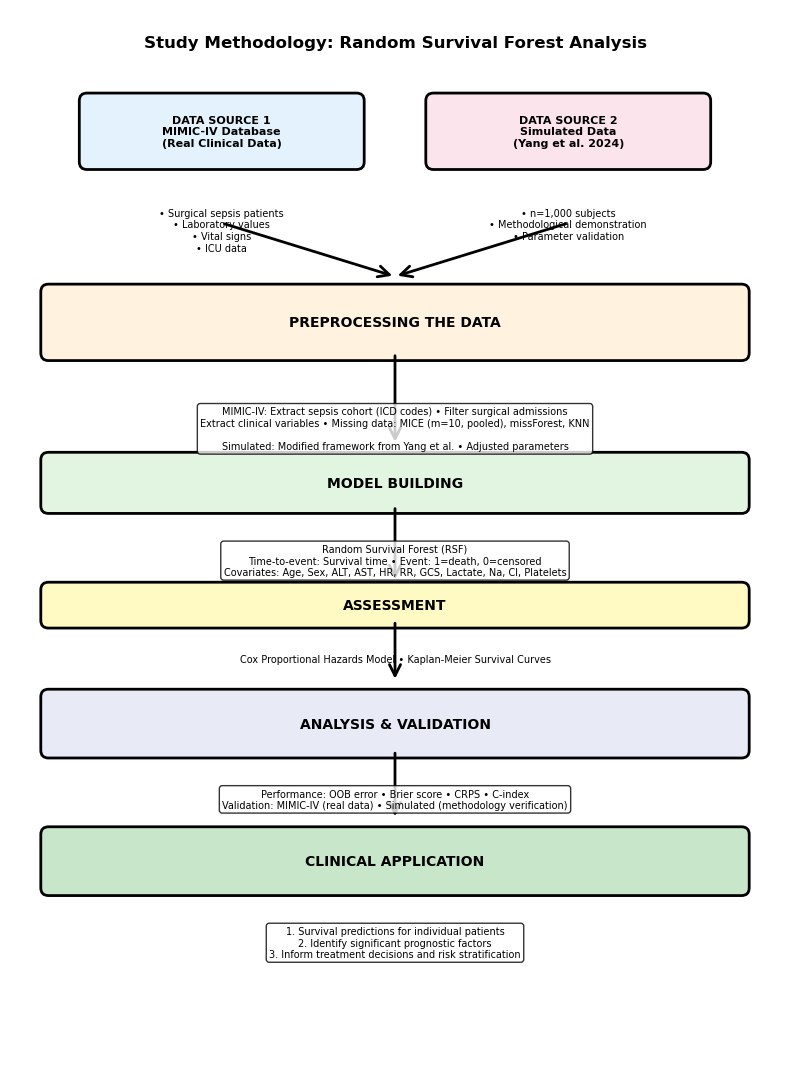

In [13]:
# ============================================================================
# Figure 1: Study Methodology Flowchart (Python version)
# ============================================================================

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import matplotlib.lines as mlines

# Create figure
fig, ax = plt.subplots(figsize=(8, 11))
ax.set_xlim(0, 10)
ax.set_ylim(0, 14)
ax.axis('off')

# Define colors
color_data = '#E3F2FD'
color_simulated = '#FCE4EC'
color_process = '#FFF3E0'
color_model = '#E1F5E1'
color_assessment = '#FFF9C4'
color_analysis = '#E8EAF6'
color_output = '#C8E6C9'

# Helper function to draw boxes
def draw_box(x, y, width, height, text, color, fontsize=9, fontweight='bold'):
    box = FancyBboxPatch((x, y), width, height, 
                         boxstyle="round,pad=0.1", 
                         edgecolor='black', 
                         facecolor=color, 
                         linewidth=2)
    ax.add_patch(box)
    ax.text(x + width/2, y + height/2, text, 
           ha='center', va='center', 
           fontsize=fontsize, fontweight=fontweight,
           wrap=True)

# Helper function to draw arrows
def draw_arrow(x1, y1, x2, y2):
    arrow = FancyArrowPatch((x1, y1), (x2, y2),
                           arrowstyle='->', 
                           mutation_scale=20, 
                           linewidth=2,
                           color='black')
    ax.add_patch(arrow)

# ============================================================================
# TITLE
# ============================================================================
ax.text(5, 13.5, 'Study Methodology: Random Survival Forest Analysis', 
       ha='center', fontsize=12, fontweight='bold')

# ============================================================================
# BOX 1: DATA SOURCES (Two boxes side by side)
# ============================================================================

# MIMIC-IV Box (Left)
draw_box(1, 12, 3.5, 0.8, 
        'DATA SOURCE 1\nMIMIC-IV Database\n(Real Clinical Data)', 
        color_data, fontsize=8)

ax.text(2.75, 11.4, 
       '• Surgical sepsis patients\n• Laboratory values\n• Vital signs\n• ICU data',
       ha='center', va='top', fontsize=7)

# Simulated Data Box (Right)
draw_box(5.5, 12, 3.5, 0.8, 
        'DATA SOURCE 2\nSimulated Data\n(Yang et al. 2024)', 
        color_simulated, fontsize=8)

ax.text(7.25, 11.4, 
       '• n=1,000 subjects\n• Methodological demonstration\n• Parameter validation',
       ha='center', va='top', fontsize=7)

# Arrows merging
draw_arrow(2.75, 11.2, 5, 10.5)
draw_arrow(7.25, 11.2, 5, 10.5)

# ============================================================================
# BOX 2: PREPROCESSING
# ============================================================================
draw_box(0.5, 9.5, 9, 0.8, 
        'PREPROCESSING THE DATA', 
        color_process, fontsize=10)

preprocessing_text = '''MIMIC-IV: Extract sepsis cohort (ICD codes) • Filter surgical admissions
Extract clinical variables • Missing data: MICE (m=10, pooled), missForest, KNN

Simulated: Modified framework from Yang et al. • Adjusted parameters'''

ax.text(5, 8.8, preprocessing_text,
       ha='center', va='top', fontsize=7, 
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

draw_arrow(5, 9.5, 5, 8.3)

# ============================================================================
# BOX 3: MODEL BUILDING
# ============================================================================
draw_box(0.5, 7.5, 9, 0.6, 
        'MODEL BUILDING', 
        color_model, fontsize=10)

model_text = '''Random Survival Forest (RSF)
Time-to-event: Survival time • Event: 1=death, 0=censored
Covariates: Age, Sex, ALT, AST, HR, RR, GCS, Lactate, Na, Cl, Platelets'''

ax.text(5, 7.0, model_text,
       ha='center', va='top', fontsize=7,
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

draw_arrow(5, 7.5, 5, 6.5)

# ============================================================================
# BOX 4: ASSESSMENT
# ============================================================================
draw_box(0.5, 6.0, 9, 0.4, 
        'ASSESSMENT', 
        color_assessment, fontsize=10)

ax.text(5, 5.5, 
       'Cox Proportional Hazards Model • Kaplan-Meier Survival Curves',
       ha='center', va='center', fontsize=7)

draw_arrow(5, 6.0, 5, 5.2)

# ============================================================================
# BOX 5: ANALYSIS
# ============================================================================
draw_box(0.5, 4.3, 9, 0.7, 
        'ANALYSIS & VALIDATION', 
        color_analysis, fontsize=10)

analysis_text = '''Performance: OOB error • Brier score • CRPS • C-index
Validation: MIMIC-IV (real data) • Simulated (methodology verification)'''

ax.text(5, 3.8, analysis_text,
       ha='center', va='top', fontsize=7,
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

draw_arrow(5, 4.3, 5, 3.4)

# ============================================================================
# BOX 6: CLINICAL APPLICATION
# ============================================================================
draw_box(0.5, 2.5, 9, 0.7, 
        'CLINICAL APPLICATION', 
        color_output, fontsize=10)

output_text = '''1. Survival predictions for individual patients
2. Identify significant prognostic factors
3. Inform treatment decisions and risk stratification'''

ax.text(5, 2.0, output_text,
       ha='center', va='top', fontsize=7,
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# ============================================================================
# SAVE
# ============================================================================
plt.tight_layout()
plt.savefig('/Users/azmannads/Downloads/Dr. Zhang/final/Figure1_Flowchart.png', 
           dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('/Users/azmannads/Downloads/Dr. Zhang/final/Figure1_Flowchart.pdf', 
           bbox_inches='tight', facecolor='white')

print("✓ Figure 1 saved as PNG and PDF")
plt.show()